In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

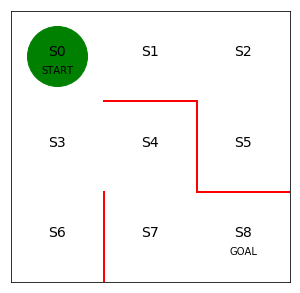

In [2]:
# init maze

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# red wall
plt.plot([1, 1], [0, 1], color='red',linewidth=2)
plt.plot([1, 2], [2, 2], color='red',linewidth=2)
plt.plot([2, 2], [2, 1], color='red',linewidth=2)
plt.plot([2, 3], [1, 1], color='red',linewidth=2)

# states
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [3]:
# init param(thetha_0) of the policy

# row (up, right, down, left)
theta_0 = np.array([[np.nan, 1, 1, np.nan], # S0
                     [np.nan, 1, np.nan, 1], # S1
                     [np.nan, np.nan, 1, 1], # S2
                     [1, 1, 1, np.nan], # S3
                     [np.nan, np.nan, 1, 1], # S4
                     [1, np.nan, np.nan, np.nan], # S5
                     [1, np.nan, np.nan, np.nan], # S6
                     [1, 1, np.nan, np.nan] # S7, S8 is goal
                    ])

In [4]:
# Q : 행동가치 함수

[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0
# * theta_0으로 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan을 부여

In [5]:
def simple_convert_into_pi_from_theta(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # average of policy
        
    pi = np.nan_to_num(pi) # Replace NaN with zero and infinity with large finite numbers.
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [6]:
# epsilon-greedy algorithm

def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    
    # explore
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    # exploit
    else:
        next_direction = direction[np.nanargmax(Q[s, :])] # nanargmax : index of nan
        
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3
        
    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]
    
    if next_direction == "up":
        s_next = s - 3
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + 3
    elif next_direction == "left":
        s_next = s - 1
        
    return s_next

In [7]:
# Sarsa algorithm

def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])
    
    return Q

In [8]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[0, np.nan]]
    
    while (1):
        a = a_next
        
        s_a_history[-1][1] = a
        
        s_next = get_s_next(s, a, Q, epsilon, pi)
        
        s_a_history.append([s_next, np.nan])
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
            
    return [s_a_history, Q]

In [9]:
eta = 0.1 # 학습률
gamma = 0.9 # 시간할인율
epsilon = 0.5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

step = []

while is_continue:
    print("============================")
    print("episode : " + str(episode))
    
    epsilon = epsilon / 2
    
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    print("step : " + str(len(s_a_history) - 1))
    
    step.append(len(s_a_history) - 1)
    
    episode += 1
    if episode > 100:
        break

episode : 1
3.0467566055670807
step : 716
episode : 2
0.07534481423374065
step : 28
episode : 3
0.1360695263631108
step : 150
episode : 4
0.10855933084964761
step : 32
episode : 5
0.10255612259011543
step : 28
episode : 6
0.08189092280971441
step : 10
episode : 7
0.07364843765308685
step : 4
episode : 8
0.08023406127696164
step : 10
episode : 9
0.07816591307173756
step : 10
episode : 10
0.07064365699875302
step : 4
episode : 11
0.06979540182298832
step : 4
episode : 12
0.06905030102843776
step : 4
episode : 13
0.06825063858589295
step : 4
episode : 14
0.06739038690197019
step : 4
episode : 15
0.06646520398251488
step : 4
episode : 16
0.0654724136051841
step : 4
episode : 17
0.06441092185358141
step : 4
episode : 18
0.06328109051832895
step : 4
episode : 19
0.06208458339736736
step : 4
episode : 20
0.060824197870126134
step : 4
episode : 21
0.059503691144560805
step : 4
episode : 22
0.05812760816925361
step : 4
episode : 23
0.05670111626902283
step : 4
episode : 24
0.05522985002085884
s

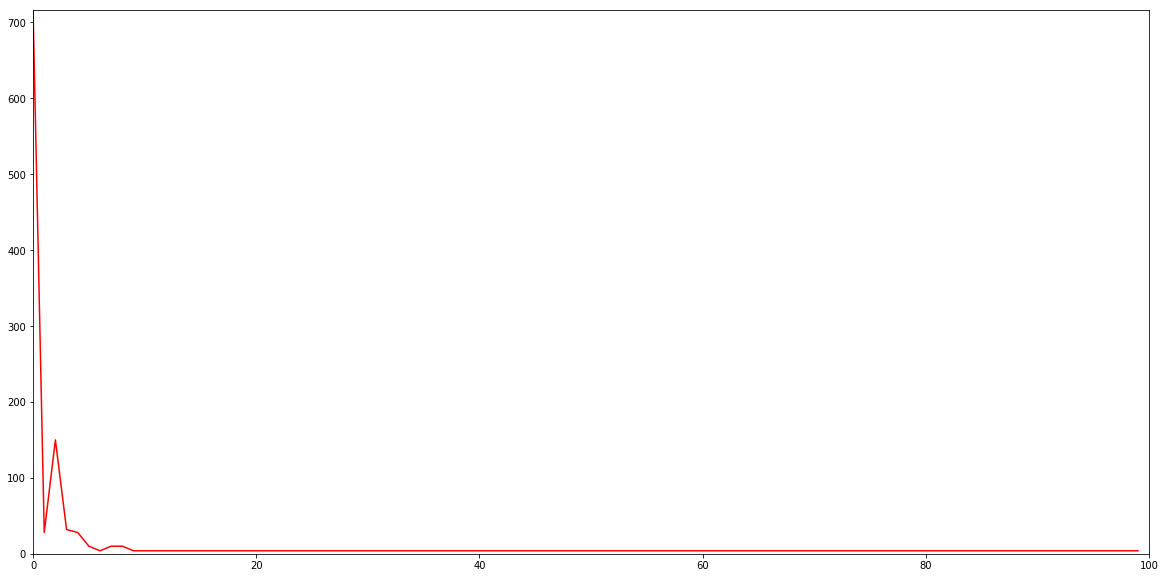

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(20,10))
plt.plot(step, 'r')
plt.axis([0, 100, 0, max(step)])
plt.show()

In [11]:
# refer url : http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML

def init():
    # initialize background
    line.set_data([], [])
    return (line,)

def animate(i):
    state = s_a_history[i][0]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

In [12]:
np.set_printoptions(precision=3, suppress=True)
print(pi)

NameError: name 'pi' is not defined